get the log data

In [82]:
import pandas
import matplotlib as plt
import numpy as np

scale_factor = 1000000

pandas.set_option("display.max_rows", None)
pandas.set_option("display.max_colwidth", None)
frames = pandas.read_csv("sc2019_profiling_log_st.csv", sep=";", quotechar="'")
frames["self_time"] = frames["self_time"].div(scale_factor)
raw_frames = pandas.read_csv("sc2019_profiling_log.csv", sep=";", quotechar="'")
raw_frames["duration (ns)"] = raw_frames["duration (ns)"].div(scale_factor)
raw_frames["start (ns)"] = raw_frames["start (ns)"].div(scale_factor)
raw_frames["end (ns)"] = raw_frames["end (ns)"].div(scale_factor)

In [97]:
print(frames.loc[10001])
print(raw_frames.loc[10001])

frame                                                           148
type                                                           Call
parent               ::WhereBaryon::input->::AstroSchulz::tableData
name                                                        GetHash
comment                                                         NaN
global_index                                                   9785
frame_index                                                       1
api                                                             CPU
start                                            2338983000257100.0
total_time                                                    200.0
self_time                                                    0.0001
self_time_scaled                                          -0.133205
total_time_scaled                                         -0.162158
Name: 10001, dtype: object
frame                                                       148
type                     

# scratchpad: inspect a single frame

In [84]:
detail_frame = frames.loc[(frames["frame"] == 1190) & (frames["parent"] == "::Left-Right::render2->::View3DGL_1::render")]
detail_frame

,frame,type,parent,name,comment,global_index,frame_index,api,start,total_time,self_time,self_time_scaled,total_time_scaled
240064,1190,Call,::Left-Right::render2->::View3DGL_1::render,GetExtents,NaN,239337,0,CPU,2.339023e+15,17000.0,0.000700,-0.144033,-0.157026
240065,1190,Call,::Left-Right::render2->::View3DGL_1::render,GetExtents,NaN,239338,0,OpenGL,1.687355e+18,6144.0,0.002176,-0.370708,-0.475726
240123,1190,Call,::Left-Right::render2->::View3DGL_1::render,Render,NaN,239396,0,CPU,2.339023e+15,14959100.0,14.949500,7.119827,6.378703
240124,1190,Call,::Left-Right::render2->::View3DGL_1::render,Render,NaN,239397,0,OpenGL,1.687355e+18,19158752.0,19.154432,2.999408,2.597103


In [95]:
detail_raw_frame = raw_frames.loc[(frames["frame"] == 1190) & (frames["parent"] == "::Left-Right::render2->::View3DGL_1::render")]
detail_raw_frame

,frame,type,parent,name,comment,global_index,frame_index,api,start (ns),end (ns),duration (ns)
240064,1190,Call,::Left-Right::render2->::View3DGL_1::render,GetExtents,NaN,239337,0,CPU,2.339023e+09,2.339023e+09,0.017000
240065,1190,Call,::Left-Right::render2->::View3DGL_1::render,GetExtents,NaN,239338,0,OpenGL,1.687355e+12,1.687355e+12,0.006144
240123,1190,Call,::Left-Right::render2->::View3DGL_1::render,Render,NaN,239396,0,CPU,2.339023e+09,2.339023e+09,14.959100
240124,1190,Call,::Left-Right::render2->::View3DGL_1::render,Render,NaN,239397,0,OpenGL,1.687355e+12,1.687355e+12,19.158752


find the render calls

In [86]:
gpu = frames.loc[(frames["parent"] == "::AnimationRenderer_1::observe->::ArrowRenderer1::rendering") & (frames["name"] == "Render") & (frames["api"] == "OpenGL") & (frames["frame"] > 0)]
cpu = frames.loc[(frames["parent"] == "::AnimationRenderer_1::observe->::ArrowRenderer1::rendering") & (frames["name"] == "Render") & (frames["api"] == "CPU") & (frames["frame"] > 0)]

f'gpu: {gpu.shape[0]} cpu: {cpu.shape[0]}'

'gpu: 1477 cpu: 1477'

In [87]:
f'min: {gpu["self_time"].min() / 1000000} (at {gpu["self_time"].idxmin()}) max: {gpu["self_time"].max() / 1000000} (at {gpu["self_time"].idxmax()}) mean: {gpu["self_time"].mean() / 1000000}'

'min: 0.0 (at 428395) max: 1.3892896000000001e-05 (at 345397) mean: 1.3677850778605281e-06'

try to find out how values are distributed

<AxesSubplot:>

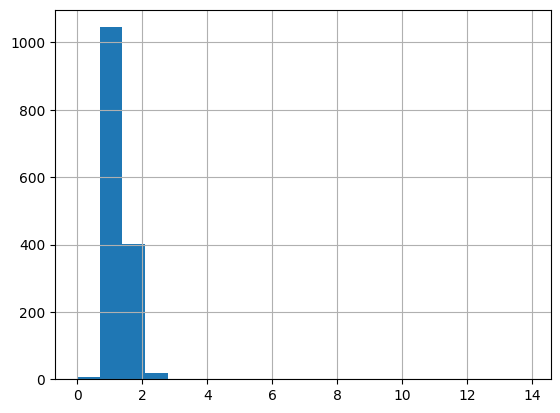

In [88]:
gpu["self_time"].hist(bins=20)
#plt.pyplot.hist(gpu["self_time"], bins=20)
#plt.pyplot.hist(gpu["self_time"], bins=np.arange(0.0,8.0,0.2))

# anomaly: view3dgl seems expensive

In [89]:
gpu = frames.loc[(frames["parent"] == "::Left-Right::render2->::View3DGL_1::render") & (frames["name"] == "Render") & (frames["api"] == "OpenGL") & (frames["frame"] == 1190)]
cpu = frames.loc[(frames["parent"] == "::Left-Right::render2->::View3DGL_1::render") & (frames["name"] == "Render") & (frames["api"] == "CPU") & (frames["frame"] == 1190)]

f'gpu: {gpu.shape[0]} cpu: {cpu.shape[0]}'

'gpu: 1 cpu: 1'

In [90]:
f'min: {gpu["self_time"].min() / 1000000} (at {gpu["self_time"].idxmin()}) max: {gpu["self_time"].max() / 1000000} (at {gpu["self_time"].idxmax()}) mean: {gpu["self_time"].mean() / 1000000}'

'min: 1.9154431999999998e-05 (at 240124) max: 1.9154431999999998e-05 (at 240124) mean: 1.9154431999999998e-05'

so expensive. why?

In [91]:
detail = raw_frames.loc[(frames["frame"] == 1190) & (frames["parent"] == "::Left-Right::render2->::View3DGL_1::render")]
detail

,frame,type,parent,name,comment,global_index,frame_index,api,start (ns),end (ns),duration (ns)
240064,1190,Call,::Left-Right::render2->::View3DGL_1::render,GetExtents,NaN,239337,0,CPU,2.339023e+09,2.339023e+09,0.017000
240065,1190,Call,::Left-Right::render2->::View3DGL_1::render,GetExtents,NaN,239338,0,OpenGL,1.687355e+12,1.687355e+12,0.006144
240123,1190,Call,::Left-Right::render2->::View3DGL_1::render,Render,NaN,239396,0,CPU,2.339023e+09,2.339023e+09,14.959100
240124,1190,Call,::Left-Right::render2->::View3DGL_1::render,Render,NaN,239397,0,OpenGL,1.687355e+12,1.687355e+12,19.158752


<AxesSubplot:>

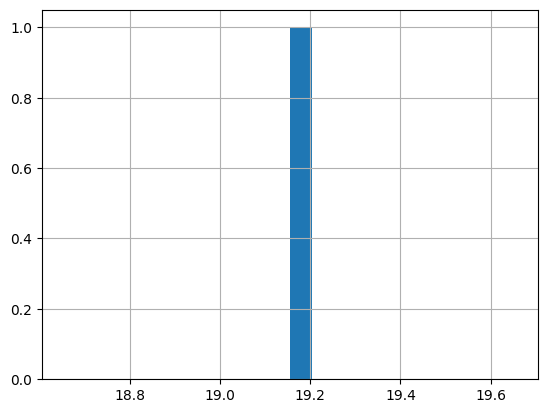

In [92]:
gpu["self_time"].hist(bins=20)

# anomaly: why is view3dgl_1 called twice in frame 1190?

In [93]:
detail_frame = frames.loc[(frames["frame"] == 1190) & (frames["parent"] == "::Left-Right::render2->::View3DGL_1::render")]
detail_frame

,frame,type,parent,name,comment,global_index,frame_index,api,start,total_time,self_time,self_time_scaled,total_time_scaled
240064,1190,Call,::Left-Right::render2->::View3DGL_1::render,GetExtents,NaN,239337,0,CPU,2.339023e+15,17000.0,0.000700,-0.144033,-0.157026
240065,1190,Call,::Left-Right::render2->::View3DGL_1::render,GetExtents,NaN,239338,0,OpenGL,1.687355e+18,6144.0,0.002176,-0.370708,-0.475726
240123,1190,Call,::Left-Right::render2->::View3DGL_1::render,Render,NaN,239396,0,CPU,2.339023e+15,14959100.0,14.949500,7.119827,6.378703
240124,1190,Call,::Left-Right::render2->::View3DGL_1::render,Render,NaN,239397,0,OpenGL,1.687355e+18,19158752.0,19.154432,2.999408,2.597103


# answer: because we had an old project that had two active views at the same time

(immediately visible in the call details)